# Anime recommender system 

In this notebook will cover the first part of building our RS which is **the preprocessing of the data** ...

Our RS is content based and collaborative filtering based .

* Content based -
    Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.
* Collaborative filtering - 
   CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).
   
we used different RS because we wanted to use differenet approaches inorder to recommended the same thing ...

## The data

The data that we are going to use is from [Anime Dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

### Data content

#### Anime.csv

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".

#### Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


#### The preprocessing is divided into two parts:
* the preprocessing of the anime.csv data for the CBRS and it is also used in the CFRS .
* the preprocessing of the rating.csv data so that it can be used in CRFS 


<h5>Additional libraries used in Content Based system</h5>

In [7]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as npb

<h5>Additional libraries used in Knn model</h5>

In [8]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

### 1-the preprocessing of the anime.csv file
As mentioned above the anime.csv file contains genre,type,rating and we will later use these in order to recommend anime based on it's gener and type which we will treat as equal and turn them into one hot encoded features for the cosine-smiliraty.<br>
we only used pandas to work dircetly with the data , the other libraries are just for the visualisation of the data ... 

In [9]:
# Importing required libraries.
import pandas as pd
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

#### Reading the Data
First we read the Anime.csv file using pandas read_csv which reads the comma separated values file .<br>
the function takes the the file path and then returns it as a [Data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) , which is pandas data strcture, and then we show the first five rows of the DF.

In [10]:
df = pd.read_csv('AnimeRS-Data/anime.csv')

df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


The data types in the dataset

In [11]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

The shape of the dataframe

In [12]:
df.shape

(12294, 7)

before we see anything we need to first check and clean missing data so we don't face any errors .

In [13]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [14]:
(df["episodes"]=="Unknown").sum()

340

As we can see we have episodes for diffrenet types have values as **unknown** and we have more than **300 empty cells** in three diffrenet columns.<br>
let's fix that by first removing the rows that contain missing data in the genre and type columns 

In [15]:
df = df.loc[df['type'].notna()]
df = df.loc[df['genre'].notna()]

and now the cells with the empty rating will be replaced by the median rating in the column

In [16]:
madian = df["rating"].median() - 1
df["rating"].fillna(madian, inplace=True)

In [17]:
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

All good :) , and now we replace the unknown with just the value 1

In [18]:
df.loc[(df["episodes"] == "Unknown"), "episodes"] = "1"

In [19]:
(df["episodes"]=="Unknown").sum()

0

We finished missing data cleaning and now we want to know what are the unique values in the type column 

In [20]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

**The distributions**

This table shows the distributaion of genres.

<AxesSubplot:>

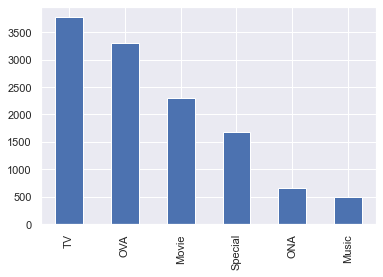

In [21]:
df['type'].value_counts().plot.bar()

<AxesSubplot:>

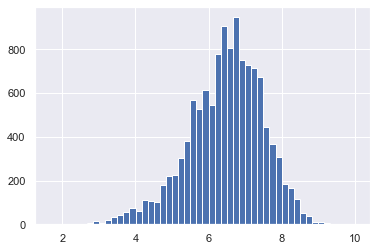

In [22]:
df['rating'].hist(bins=50)

From the two graphs we can interpret that the most anime types are tv and ova and most ratings are between ~5.5 -> ~8

In the anime names after we have made the code we have noticed that a lot of anime names need cleaning and we wanted them to be in lower case for easier finding

In [23]:
df['name'].head()

0                      Kimi no Na wa.
1    Fullmetal Alchemist: Brotherhood
2                            Gintama°
3                         Steins;Gate
4                       Gintama&#039;
Name: name, dtype: object

as shown above we can see that some have names that need cleaning

In [24]:
df["name"] = df["name"].str.replace('&#039;', '\'')
df["name"] = df["name"].str.replace('\'', '1')
df["name"] = df["name"].str.replace('[^\s\w]', '')
df["name"] = df["name"].str.lower()
## we reached these lines of code after lots of trial and error and optimizing the cleaning 
## so please take it as it is

In [25]:
df['name'].head()

0                      kimi no na wa
1    fullmetal alchemist brotherhood
2                            gintama
3                         steinsgate
4                           gintama1
Name: name, dtype: object

the dataset is cleaned ready to be worked with

In [26]:
df.to_csv('AnimeRS-Data/clean_anime.csv', index=False)

### Content based using cosine similraty
after we have cleaned the data and saved it for later use , we now continue preparing the df to be used for the our CBRS

In [27]:
clean_anime = pd.read_csv('AnimeRS-Data/clean_anime.csv') # loading the cleaned data

in order to calculate the cosine similarity  we first need to calculate the weighted averge and the idea is that, if you have very few votes for your particular movie, you don't put much trust on it, and lean instead towards a conservative estimate.
we used this formula:
![weighted rating](AnimeRS-Data/weighted-rating.png)<br>
and what we've done is we created the term which consists of the number of members / the quantile + the number of members 
and that for us a is some term and we multiplayed that with rating + the term multiplayed by the mean rating<br>

**number of members is how many people rated a specific anime**<br>
**the quantile is the member at 0.75 position in the normal distribution of the data**


In [28]:
def calc_quantile_mean(clean_anime):
    """
    :var quantile: takes the member at 0.75 position in the normal distribution of the data
    :var mean: calculates the average of the rating of each anime.
    """
    quantile = clean_anime.members.quantile(0.75)
    mean = clean_anime.rating.mean()
    return quantile, mean


def weighted_rating(clean_anime, quantile, mean):
    """
    :var term: gets the total users who rated each anime.
    """
    term = clean_anime['members'] / (quantile + clean_anime['members'])
    return clean_anime['rating'] * term + (1 - term) * mean

In [29]:
quantile, mean = calc_quantile_mean(clean_anime)
clean_anime['community_rating'] = clean_anime.apply(weighted_rating, axis=1, args=(quantile, mean))

In [30]:
clean_anime[['community_rating','rating']].head()

,community_rating,rating
0,9.238219,9.37
1,9.226824,9.26
2,9.035516,9.25
3,9.132247,9.17
4,9.000209,9.16


we now have the community rating wich is the weighted rating for each anime, and finally after we calculated that we can create a **one hot encoded vector** for each anime where each type and genre is equal and if the anime belongs to this genre or type it will have a value of 1 else 0

In [31]:
clean_anime.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True) #we drop unwanted columns 

In [32]:
clean_anime = pd.concat(
    [clean_anime, clean_anime['type'].str.get_dummies(), clean_anime['genre'].str.get_dummies(sep=',')], axis=1)

In [33]:
clean_anime.head(10)

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,9.238219,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fullmetal alchemist brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.226824,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.035516,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,steinsgate,"Sci-Fi, Thriller",TV,9.132247,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,gintama1,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.000209,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,haikyuu karasuno koukou vs shiratorizawa gakue...,"Comedy, Drama, School, Shounen, Sports",TV,8.901184,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,hunter x hunter 2011,"Action, Adventure, Shounen, Super Power",TV,9.071643,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,ginga eiyuu densetsu,"Drama, Military, Sci-Fi, Space",OVA,8.830457,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,gintama movie kanketsuhen yorozuya yo eien nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,8.793874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,gintama1 enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.831784,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


As we can see now we have for each anime a vector of 176 different columns or **features**

In [34]:
#checking for duplicated columns
clean_anime.columns.duplicated()


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [35]:
# we now remove the duplicated columns
clean_anime = clean_anime.loc[:, ~clean_anime.columns.duplicated()]

In [36]:
clean_anime.columns

Index(['name', 'genre', 'type', 'community_rating', 'Movie', 'Music', 'ONA',
       'OVA', 'Special', 'TV', ' Adventure', ' Cars', ' Comedy', ' Dementia',
       ' Demons', ' Drama', ' Ecchi', ' Fantasy', ' Game', ' Harem', ' Hentai',
       ' Historical', ' Horror', ' Josei', ' Kids', ' Magic', ' Martial Arts',
       ' Mecha', ' Military', ' Music', ' Mystery', ' Parody', ' Police',
       ' Psychological', ' Romance', ' Samurai', ' School', ' Sci-Fi',
       ' Seinen', ' Shoujo', ' Shoujo Ai', ' Shounen', ' Shounen Ai',
       ' Slice of Life', ' Space', ' Sports', ' Super Power', ' Supernatural',
       ' Thriller', ' Vampire', ' Yaoi', ' Yuri', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', '

In [37]:
clean_anime.columns.shape

(91,)

and finally after we cleaned everthing we now prepare the feature vector for the cosine similarity

In [38]:
anime_features = clean_anime.loc[:, "Movie":].copy()

In [39]:
anime_features.head(6)

,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After that we have for each anime a one hot encoded feature vector for the consine similarity which will be shown now.

<h4>In our Content Based system we give a recomendation based on similarity of the features to the vector of the user's input.</h4> 

**note** results below.

In [ ]:
cosine_sim_val = cosine_sim(anime_features)
anime_index = pd.Series(clean_anime.index, index=clean_anime.name).drop_duplicates()
results = get_recommendation(user_input.lower(), cosine_sim_val, clean_anime, anime_index)

### Collaborative filtering :
after we preprocessed for the CBRS we now do the same thing for this recommender system,
in this method we will use knn using cosine similarity so we will need the the rating.csv file and later for the knn model we use cleaned_anime.csv file.<br>
**we first start by loading the rating.csv**<br>
the rating file contains the rating for each user per anime so if the user didn't rate an anime the rating will be -1

<h4>In our KNN model we give a recomendation based on similarity of the features to the vector of the user's input.</h4>

We will be using the collaborative filtering technique.
The system will recommend anime based on the nearest rating between the ratings of user's anime and the ratings of other anime.

In [ ]:
rating = pd.read_csv('AnimeRS-Data/rating.csv')

In [ ]:
rating.head()

In [ ]:
rating.shape

In [ ]:
rating.isnull().sum() # we have no null values so let's get started

#### Remove anime with low count of ratings and users who gave low count of ratings
We will only consider popular anime (rating count over 250) and users who gave lots of rating on different anime (>100)

In [ ]:
anime_ratings_count = rating.groupby(by='anime_id').count()['rating'].reset_index().rename(
    columns={'rating': 'rating_count'})

In [ ]:
anime_ratings_count

In [ ]:
anime_ratings_count=anime_ratings_count[anime_ratings_count['rating_count'] > 250]

In [ ]:
anime_ratings_count

In [ ]:
user_rating_count = rating.groupby(by='user_id').count()['rating'].reset_index().rename(
    columns={'rating': 'rating_count'})

In [ ]:
user_rating_count

In [ ]:
user_rating_count=user_rating_count[user_rating_count['rating_count'] > 100]

In [ ]:
user_rating_count

In [ ]:
def join_tables(filter_anime_rating, filter_user_rating, rating):
    filtered_rating_anime = rating[rating['anime_id'].isin(filter_anime_rating['anime_id'])]
    filtered_rating = filtered_rating_anime[filtered_rating_anime['user_id'].isin(filter_user_rating['user_id'])]
    return filtered_rating

<h4>creating a joined table using the three data frames</h4>

In [ ]:
joined_table = join_tables(anime_ratings_count, user_rating_count, rating)

In [ ]:
joined_table

we now convert the table into a matrix for easier access to the data

In [ ]:
from scipy.sparse import csr_matrix ## the csr matrix is used in order to save data
def convert_to_matrix(joined_table):
    """
    converting table to matrix for easier access to data.
    """
    rating_matrix = joined_table.pivot_table(index='anime_id', columns='user_id', values='rating').fillna(0)
    csr_rating_matrix = csr_matrix(rating_matrix.values)
    return rating_matrix, csr_rating_matrix

**csr_rating_matrix** is a form of matrix that contains nonzero values as apposed to the **ratings_matrix**.

In [ ]:
rating_matrix, csr_rating_matrix = convert_to_matrix(joined_table)

In [ ]:
print(csr_rating_matrix)

(0, 4)	-1.0
  (0, 7)	9.0
  (0, 12)	10.0
  (0, 14)	10.0
  (0, 15)	10.0
  (0, 16)	-1.0
  (0, 21)	10.0
  (0, 32)	9.0
  (0, 33)	10.0
  (0, 36)	10.0
  (0, 39)	9.0
  (0, 40)	8.0
  (0, 44)	7.0
  (0, 45)	8.0
  (0, 49)	10.0
  (0, 51)	8.0
  (0, 52)	10.0
  (0, 55)	8.0
  (0, 56)	9.0
  (0, 62)	10.0
  (0, 64)	9.0
  (0, 65)	-1.0
  (0, 67)	-1.0
  (0, 69)	7.0
  (0, 71)	-1.0
  :	:
  (3317, 24343)	9.0
  (3317, 24345)	-1.0
  (3317, 24359)	10.0
  (3317, 24383)	-1.0
  (3317, 24385)	10.0
  (3317, 24391)	8.0
  (3317, 24392)	-1.0
  (3317, 24403)	8.0
  (3317, 24423)	-1.0
  (3317, 24426)	8.0
  (3317, 24429)	8.0
  (3317, 24444)	-1.0
  (3317, 24450)	9.0
  (3317, 24459)	8.0
  (3317, 24468)	7.0
  (3317, 24469)	8.0
  (3317, 24471)	-1.0
  (3317, 24480)	9.0
  (3317, 24493)	-1.0
  (3317, 24541)	8.0
  (3317, 24546)	-1.0
  (3317, 24557)	8.0
  (3317, 24579)	10.0
  (3317, 24583)	8.0
  (3317, 24631)	9.0

In [ ]:
rating_matrix 

<h4>Fit the matrix into nearest neighbor</h4>

In [ ]:
knn_model = NearestNeighbors(metric='cosine')
knn_model.fit(csr_rating_matrix)

That's it for the preprocessing of the rating data which will be used in part two for building the knn model along with the clean_anime.csv